# State Schema

## Review

In module 1, we laid the foundations! We built up to an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions

And, we showed how to serve it locally in LangGraph Studio or deploy it with LangGraph Cloud.

## Goals

In this module, we're going to build a deeper understanding of both state and memory.

First, let's review a few different ways to define your state schema.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph
%pip install -q langchain-google-genai
%pip install -q -U langchain_core langchain-community

In [24]:
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY is not set in the .env file.")

print("API key loaded from .env file.")

API key loaded from .env file.


## Schema

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

## TypedDict

As we mentioned in Module 1, we can use the `TypedDict` class from python's `typing` module.

It allows you to specify keys and their corresponding value types.

But, note that these are type hints.

They can used by static type checkers (like [mypy](https://github.com/python/mypy)) or IDEs to catch potential type-related errors before the code is run.

But they are not enforced at runtime!

In [5]:
from typing_extensions import TypedDict
 
class TypedDictState(TypedDict):
    foo:str
    bar:str
    ball:str
    
typed_dict = TypedDictState(foo=None, bar=None, baz=None)
print(typed_dict['foo'])    
print(typed_dict['bar'])     
print(typed_dict['baz'])    

None
None
None


For more specific value constraints, you can use things like the `Literal` type hint.

Here, `mood` can only be either "happy" or "sad".

In [1]:
from typing_extensions import TypedDict
from typing import Literal
 
class TypedDictState(TypedDict):
    foo:str
    bar:str
    ball:Literal["hard_ball","child_ball"]
    
typed_dict = TypedDictState(foo=None, bar=None, baz=None,ball="ball")
print(typed_dict['foo'])    
print(typed_dict['bar'])     
print(typed_dict['baz'])    
print(typed_dict['ball'])    

None
None
None
ball


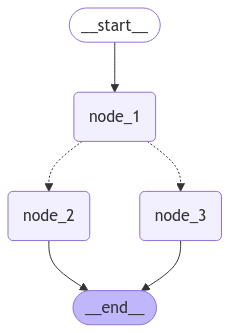

In [9]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]
    
def node_1(state: TypedDictState):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state: TypedDictState):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state: TypedDictState):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state: TypedDictState) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
       return "node_2"
    return "node_3"

# Build graph
builder: StateGraph = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can use our defined state class (e.g., here `TypedDictState`) in LangGraph by simply passing it to `StateGraph`.

And, we can think about each state key just a "channel" in our graph.

As discussed in Module 1, we overwrite the value of a specified key or "channel" in each node.

## Dataclass

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [2]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]     

In [3]:
valid_data_class: DataclassState = DataclassState(mood="mad", name="hi",  )
# Note: 'mood' must be either "happy" or "sad", but "mad" is provided, which is invalid. But dataclass is not raise an error
 

In [6]:
invalid_dataclass: DataclassState = DataclassState(mood="mad", name="hi", random_field= "user")
 

TypeError: DataclassState.__init__() got an unexpected keyword argument 'random_field'

In [7]:

invalid_dataclass: DataclassState = DataclassState(mood="mad")

TypeError: DataclassState.__init__() missing 1 required positional argument: 'name'

To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`:

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.

This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

In [8]:
print(valid_data_class.mood)
print(valid_data_class.name)

mad
hi


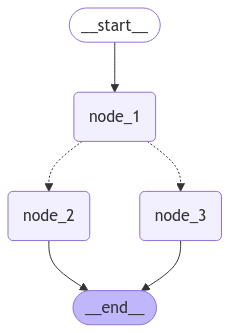

In [10]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]
    
def node_1(state: DataclassState) -> dict:
    print("---Node 1---")
    return {"name": state.name + " is ... "}

def node_2(state: DataclassState) -> dict:
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state: DataclassState) -> dict:
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state: TypedDictState) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
       return "node_2"
    return "node_3"


# Build graph
builder: StateGraph = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph: DataclassState = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))    

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime.

This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) is a data validation and settings management library using Python type annotations.

It's particularly well-suited [for defining state schemas in LangGraph](https://langchain-ai.github.io/langgraph/how-tos/state-model/) due to its validation capabilities.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [13]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: Literal["happy", "sad"]
    
    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        if value not in ["happy", "sad"]:
            raise ValidationError("mood must be either 'happy' or'sad'")
        return value

In [15]:
try:
    valid_pydantic: PydanticState = PydanticState(mood="mad", name="hi")
    print(valid_pydantic.mood)
    print(valid_pydantic.name)
except ValidationError as e:
    print(f"ValidationError {e}")    

ValidationError 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/literal_error


In [16]:
try:
    valid_pydantic: PydanticState = PydanticState(mood="happy", name="hi")
    print(valid_pydantic.mood)
    print(valid_pydantic.name)
except ValidationError as e:
    print(f"ValidationError {e}")    

happy
hi


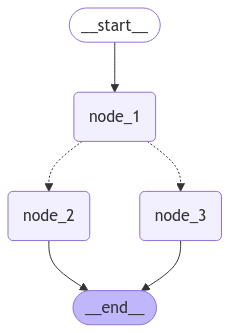

In [17]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: Literal["happy", "sad"]
    
    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        if value not in ["happy", "sad"]:
            raise ValidationError("mood must be either 'happy' or'sad'")
        return value
    
def node_1(state: PydanticState) -> dict:
    print("---Node 1---")
    return {"name": state.name + " is ... "}

def node_2(state: PydanticState) -> dict:
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state: PydanticState) -> dict:
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state: PydanticState) -> Literal["node_2", "node_3"]:
    if random.random() < 0.5:
       return "node_2"
    return "node_3"


# Build graph
builder: StateGraph = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph: DataclassState = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))    

In [18]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

In [19]:
graph.invoke(PydanticState(name="Lance",mood="mad"))

ValidationError: 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/literal_error

### A Pydantic React Agent


## @tool
The @tool decorator adds metadata to your functions, making them easily discoverable and usable within LangChain workflows.
The @tool decorator is a special tag that tells LangChain:

"This function is a tool that can be used by an agent or workflow."

It automatically adds metadata (like the tool’s name, description, and arguments) to the function.

In [20]:
from langchain_core.tools import tool


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two numbers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}


In [21]:
from langchain_core.tools import tool

 
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b
 
print(multiply.name)
print(multiply.description)
print(multiply.args)

AttributeError: 'function' object has no attribute 'name'

content='333 * 4 = 1332\n\n1332 + 3 = 1335\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-25e77653-3f56-4534-b823-ef8fd1750d39-0' usage_metadata={'input_tokens': 15, 'output_tokens': 27, 'total_tokens': 42, 'input_token_details': {'cache_read': 0}}


content='' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'MALFORMED_FUNCTION_CALL', 'safety_ratings': []} id='run-6d42907c-23fb-4c51-8a8a-30190428345a-0' usage_metadata={'input_tokens': 157, 'output_tokens': 0, 'total_tokens': 157, 'input_token_details': {'cache_read': 0}}


# What is Sequence?
Sequence is a type hint in Python that represents an ordered collection of items.

It is a generic type, meaning it can be used for any ordered collection, such as lists, tuples, or other sequence-like objects.

In [ ]:
from typing import Sequence

def print_sequence(items: Sequence[str]):
    """
    This function takes a sequence of strings and prints each item.
    """
    for item in items:
        print(item)

# List of strings
fruits_list = ["apple", "banana", "cherry"]
print_sequence(fruits_list)

# Tuple of strings
fruits_tuple = ("apple", "banana", "cherry")
print_sequence(fruits_tuple)

In [48]:

from langchain_core.tools import tool 
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import ToolNode
import operator
from typing import Annotated, Sequence
from langchain_core.messages import BaseMessage
from pydantic import BaseModel

class AgentState(BaseModel):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
@tool
def multiply(num1:float,num2:float)->int:
    """
    Multiply of two numbers like num1 and num2
    Args:
    num1:first float,
    num2:second float
"""
    return num1 * num2

@tool
def add(num1:float,num2:float)->int:
    """
    Add two numbers like num1 and num2 
    Args:
    num1:first float,
    num2:second float
    """
    return num1 + num2
    
    return a * b

 
 


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)
llm_with_tools = llm.bind_tools(tools)

def should_continue(state: AgentState) -> Literal["end", "continue"]:
    messages = state.messages
    last_message = messages[-1] 
    if not last_message.tool_calls:
        return "end" 
    else:
        return "continue"
 
def call_model(state: AgentState):
    messages = state.messages
    response = llm_with_tools.invoke(messages) 
    return {"messages": [response]}

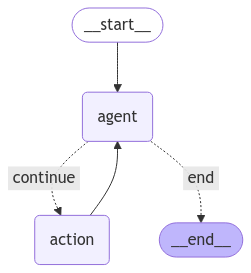

In [46]:
from langgraph.graph import END, StateGraph, START 
workflow: StateGraph = StateGraph(AgentState) 
workflow.add_node("agent", call_model)
workflow.add_node("action", ToolNode([multiply, add])) 
workflow.add_edge(START, "agent") 
workflow.add_conditional_edges( 
    "agent", 
    should_continue, 
    { 
        "continue": "action", 
        "end": END,
    },
) 
workflow.add_edge("action", "agent") 
app: CompiledStateGraph = workflow.compile()
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what")]}
for chunk in app.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [47]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is multiple of 3 and 4")]}
for chunk in app.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is multiple of 3 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (b17d5665-aef9-4a74-9f18-5c2770042572)
 Call ID: b17d5665-aef9-4a74-9f18-5c2770042572
  Args:
    num2: 4.0
    num1: 3.0
================================= Tool Message =================================
Name: multiply

3.0
================================== Ai Message ==================================

The multiple of 3 and 4 is 12.
